In [2]:
import torch

## Simple model fitting
using temperature data--try to convert unknown units to Celsius.

In [49]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # Celsius
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # unknown
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Trying a linear model, i.e., estimate w and b s.t. the error is minimized and $t_c = w t_u + b$.

Need to choose a loss function, which the learning algorithm attempts to minimize. Consider squared error and absolute error. Note that squared error greater penalizes wildly wrong results--prefers to have more slightly off errors than a few very off errors.

Define model and loss.

In [50]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    '''
    Mean squared loss
    '''
    sq_diffs = (t_p - t_c)**2
    return sq_diffs.mean()

In [51]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [52]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

### Aside
pytorch uses broadcasting, meaning we can add a scalar to a multidim tensor and it will broadcast that scalar up in dimensions so that the result makes sense.

In [11]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)
print(f'shapes: x: {x.shape}, y: {y.shape}\n\tz: {z.shape}, a: {a.shape}')

shapes: x: torch.Size([]), y: torch.Size([3, 1])
	z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])


In [15]:
(x * y).shape # scalar * elements

torch.Size([3, 1])

In [16]:
(y * z).shape # matrix mult

torch.Size([3, 3])

In [20]:
(y * a).shape # broadcast the last 2 dimensions of a to 3, 1 to match y

torch.Size([2, 3, 1])

In [21]:
(a * z).shape # broadcast the last 2 dimensions of a to 1, 3 to match z

torch.Size([2, 1, 3])

## Gradient Descent

In [54]:
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c))/(2.0 * delta)
loss_rate_of_change_w # in some neighborhood of w and b, a unit increase in w changes the loss by this amount

tensor(4517.2974)

Change w proportionally to loss and change slowly because the rate of change could differ dramatically even in small neighborhoods around w. So, learning is scaled by a small factor called $\eta$, the learning rate.

If change is negative, then need to increase the weight to minimize loss, as a unit increase in w will decrease loss.\
If change is positive, then need to decrease the weight to minimize loss, as a unit increase in w will increase loss.

In [47]:
learning_rate = 1e-2
w = w - learning_rate*loss_rate_of_change_w

In [48]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c))/(2.0 * delta)
b = b - learning_rate*loss_rate_of_change_b

tensor(-2603314.)

Now solve analytically (i.e., without arbitrary delta).

In [56]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.shape[0]
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

By chain rule,
$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial t_p}\frac{\partial t_p}{\partial w}$$ similarly for b and
$$\nabla_{w, b}L = \left(\frac{\partial L}{\partial w}, \frac{\partial L}{\partial b}\right)$$

In [58]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()]) # need to sum because we want one scalar for each term in gradient

Training loop

In [75]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(n_epochs):
        w, b = params
        t_p = model(t_u, w, b) # forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b) # backward pass         
        params -= learning_rate*grad
        print(f'Epoch {epoch}, Loss {float(loss)}')
        print(f'\t Params: {params}')
        print(f'\t Grad: {grad}')
    return params

In [76]:
training_loop(100, 1e-2, torch.tensor([1.0, 0.0]), t_u, t_c)

Epoch 0, Loss 1763.884765625
	 Params: tensor([-44.1730,  -0.8260])
	 Grad: tensor([4517.2964,   82.6000])
Epoch 1, Loss 5802484.5
	 Params: tensor([2568.4011,   45.1637])
	 Grad: tensor([-261257.4062,   -4598.9702])
Epoch 2, Loss 19408029696.0
	 Params: tensor([-148527.7344,   -2616.3931])
	 Grad: tensor([15109614.0000,   266155.6875])
Epoch 3, Loss 64915905708032.0
	 Params: tensor([8589999.0000,  151310.8906])
	 Grad: tensor([-8.7385e+08, -1.5393e+07])
Epoch 4, Loss 2.1713052546105344e+17
	 Params: tensor([-4.9680e+08, -8.7510e+06])
	 Grad: tensor([5.0539e+10, 8.9023e+08])
Epoch 5, Loss 7.262575831529281e+20
	 Params: tensor([2.8732e+10, 5.0610e+08])
	 Grad: tensor([-2.9229e+12, -5.1486e+10])
Epoch 6, Loss 2.429183416467663e+24
	 Params: tensor([-1.6617e+12, -2.9270e+10])
	 Grad: tensor([1.6904e+14, 2.9776e+12])
Epoch 7, Loss 8.125122549611731e+27
	 Params: tensor([9.6102e+13, 1.6928e+12])
	 Grad: tensor([-9.7764e+15, -1.7221e+14])
Epoch 8, Loss 2.717688212084259e+31
	 Params: tenso

tensor([nan, nan])

Parameter values great increased -- losses approached inf. Want convergence, not divergence. Choose smaller learning rate to start.

In [77]:
training_loop(100, 1e-4, torch.tensor([1.0, 0.0]), t_u, t_c)

Epoch 0, Loss 1763.884765625
	 Params: tensor([ 0.5483, -0.0083])
	 Grad: tensor([4517.2964,   82.6000])
Epoch 1, Loss 323.09051513671875
	 Params: tensor([ 0.3623, -0.0118])
	 Grad: tensor([1859.5493,   35.7843])
Epoch 2, Loss 78.92963409423828
	 Params: tensor([ 0.2858, -0.0135])
	 Grad: tensor([765.4666,  16.5122])
Epoch 3, Loss 37.5528450012207
	 Params: tensor([ 0.2543, -0.0143])
	 Grad: tensor([315.0790,   8.5787])
Epoch 4, Loss 30.540283203125
	 Params: tensor([ 0.2413, -0.0149])
	 Grad: tensor([129.6733,   5.3127])
Epoch 5, Loss 29.351154327392578
	 Params: tensor([ 0.2360, -0.0153])
	 Grad: tensor([53.3495,  3.9682])
Epoch 6, Loss 29.148883819580078
	 Params: tensor([ 0.2338, -0.0156])
	 Grad: tensor([21.9304,  3.4148])
Epoch 7, Loss 29.113847732543945
	 Params: tensor([ 0.2329, -0.0159])
	 Grad: tensor([8.9964, 3.1869])
Epoch 8, Loss 29.107145309448242
	 Params: tensor([ 0.2325, -0.0162])
	 Grad: tensor([3.6721, 3.0930])
Epoch 9, Loss 29.105247497558594
	 Params: tensor([ 0.2

tensor([ 0.2327, -0.0438])

Parameter updates are small -- could change this by making learning_rate adaptive.

Also, the first-epoch gradient for the weight is much larger (~50x) than the gradient for the bias. Try to normalize weights so that we can use the same learning rate for both.

In [70]:
t_un = 0.1 * t_u # shrinks inputs so gradient isn't too different

In [78]:
training_loop(100, 1e-2, torch.tensor([1.0, 0.0]), t_un, t_c)

Epoch 0, Loss 80.36434173583984
	 Params: tensor([1.7761, 0.1064])
	 Grad: tensor([-77.6140, -10.6400])
Epoch 1, Loss 37.574913024902344
	 Params: tensor([2.0848, 0.1303])
	 Grad: tensor([-30.8623,  -2.3864])
Epoch 2, Loss 30.871076583862305
	 Params: tensor([2.2094, 0.1217])
	 Grad: tensor([-12.4631,   0.8587])
Epoch 3, Loss 29.756193161010742
	 Params: tensor([2.2616, 0.1004])
	 Grad: tensor([-5.2218,  2.1327])
Epoch 4, Loss 29.507152557373047
	 Params: tensor([2.2853, 0.0740])
	 Grad: tensor([-2.3715,  2.6310])
Epoch 5, Loss 29.3924560546875
	 Params: tensor([2.2978, 0.0458])
	 Grad: tensor([-1.2492,  2.8241])
Epoch 6, Loss 29.298828125
	 Params: tensor([2.3059, 0.0168])
	 Grad: tensor([-0.8071,  2.8970])
Epoch 7, Loss 29.208717346191406
	 Params: tensor([ 2.3122, -0.0124])
	 Grad: tensor([-0.6325,  2.9227])
Epoch 8, Loss 29.119415283203125
	 Params: tensor([ 2.3178, -0.0417])
	 Grad: tensor([-0.5633,  2.9298])
Epoch 9, Loss 29.030488967895508
	 Params: tensor([ 2.3232, -0.0710])
	 

tensor([ 2.7553, -2.5162])

In [85]:
params = training_loop(5000, 1e-2, torch.tensor([1.0, 0.0]), t_un, t_c)

Epoch 0, Loss 80.36434173583984
	 Params: tensor([1.7761, 0.1064])
	 Grad: tensor([-77.6140, -10.6400])
Epoch 1, Loss 37.574913024902344
	 Params: tensor([2.0848, 0.1303])
	 Grad: tensor([-30.8623,  -2.3864])
Epoch 2, Loss 30.871076583862305
	 Params: tensor([2.2094, 0.1217])
	 Grad: tensor([-12.4631,   0.8587])
Epoch 3, Loss 29.756193161010742
	 Params: tensor([2.2616, 0.1004])
	 Grad: tensor([-5.2218,  2.1327])
Epoch 4, Loss 29.507152557373047
	 Params: tensor([2.2853, 0.0740])
	 Grad: tensor([-2.3715,  2.6310])
Epoch 5, Loss 29.3924560546875
	 Params: tensor([2.2978, 0.0458])
	 Grad: tensor([-1.2492,  2.8241])
Epoch 6, Loss 29.298828125
	 Params: tensor([2.3059, 0.0168])
	 Grad: tensor([-0.8071,  2.8970])
Epoch 7, Loss 29.208717346191406
	 Params: tensor([ 2.3122, -0.0124])
	 Grad: tensor([-0.6325,  2.9227])
Epoch 8, Loss 29.119415283203125
	 Params: tensor([ 2.3178, -0.0417])
	 Grad: tensor([-0.5633,  2.9298])
Epoch 9, Loss 29.030488967895508
	 Params: tensor([ 2.3232, -0.0710])
	 

	 Grad: tensor([-0.4348,  2.4615])
Epoch 113, Loss 21.255117416381836
	 Params: tensor([ 2.8167, -2.8641])
	 Grad: tensor([-0.4341,  2.4573])
Epoch 114, Loss 21.192907333374023
	 Params: tensor([ 2.8211, -2.8886])
	 Grad: tensor([-0.4334,  2.4531])
Epoch 115, Loss 21.130897521972656
	 Params: tensor([ 2.8254, -2.9131])
	 Grad: tensor([-0.4326,  2.4490])
Epoch 116, Loss 21.06910514831543
	 Params: tensor([ 2.8297, -2.9375])
	 Grad: tensor([-0.4319,  2.4448])
Epoch 117, Loss 21.007526397705078
	 Params: tensor([ 2.8340, -2.9619])
	 Grad: tensor([-0.4311,  2.4407])
Epoch 118, Loss 20.946149826049805
	 Params: tensor([ 2.8383, -2.9863])
	 Grad: tensor([-0.4304,  2.4365])
Epoch 119, Loss 20.884981155395508
	 Params: tensor([ 2.8426, -3.0106])
	 Grad: tensor([-0.4297,  2.4324])
Epoch 120, Loss 20.824024200439453
	 Params: tensor([ 2.8469, -3.0349])
	 Grad: tensor([-0.4290,  2.4282])
Epoch 121, Loss 20.763273239135742
	 Params: tensor([ 2.8512, -3.0592])
	 Grad: tensor([-0.4282,  2.4241])
Epo

Epoch 227, Loss 15.365615844726562
	 Params: tensor([ 3.2662, -5.4085])
	 Grad: tensor([-0.3576,  2.0243])
Epoch 228, Loss 15.323395729064941
	 Params: tensor([ 3.2698, -5.4287])
	 Grad: tensor([-0.3570,  2.0209])
Epoch 229, Loss 15.281316757202148
	 Params: tensor([ 3.2733, -5.4489])
	 Grad: tensor([-0.3564,  2.0175])
Epoch 230, Loss 15.2393798828125
	 Params: tensor([ 3.2769, -5.4690])
	 Grad: tensor([-0.3558,  2.0140])
Epoch 231, Loss 15.197585105895996
	 Params: tensor([ 3.2804, -5.4891])
	 Grad: tensor([-0.3552,  2.0106])
Epoch 232, Loss 15.155932426452637
	 Params: tensor([ 3.2840, -5.5092])
	 Grad: tensor([-0.3546,  2.0072])
Epoch 233, Loss 15.114424705505371
	 Params: tensor([ 3.2875, -5.5292])
	 Grad: tensor([-0.3540,  2.0038])
Epoch 234, Loss 15.073055267333984
	 Params: tensor([ 3.2911, -5.5492])
	 Grad: tensor([-0.3534,  2.0004])
Epoch 235, Loss 15.03182315826416
	 Params: tensor([ 3.2946, -5.5692])
	 Grad: tensor([-0.3528,  1.9970])
Epoch 236, Loss 14.990734100341797
	 Par

Epoch 350, Loss 11.11428165435791
	 Params: tensor([ 3.6628, -7.6534])
	 Grad: tensor([-0.2901,  1.6423])
Epoch 351, Loss 11.086490631103516
	 Params: tensor([ 3.6657, -7.6698])
	 Grad: tensor([-0.2896,  1.6395])
Epoch 352, Loss 11.058796882629395
	 Params: tensor([ 3.6686, -7.6861])
	 Grad: tensor([-0.2892,  1.6368])
Epoch 353, Loss 11.031192779541016
	 Params: tensor([ 3.6714, -7.7025])
	 Grad: tensor([-0.2886,  1.6340])
Epoch 354, Loss 11.00368595123291
	 Params: tensor([ 3.6743, -7.7188])
	 Grad: tensor([-0.2882,  1.6312])
Epoch 355, Loss 10.976269721984863
	 Params: tensor([ 3.6772, -7.7351])
	 Grad: tensor([-0.2877,  1.6284])
Epoch 356, Loss 10.94894790649414
	 Params: tensor([ 3.6801, -7.7513])
	 Grad: tensor([-0.2872,  1.6257])
Epoch 357, Loss 10.92171859741211
	 Params: tensor([ 3.6829, -7.7676])
	 Grad: tensor([-0.2867,  1.6229])
Epoch 358, Loss 10.894580841064453
	 Params: tensor([ 3.6858, -7.7838])
	 Grad: tensor([-0.2862,  1.6201])
Epoch 359, Loss 10.867536544799805
	 Para

	 Params: tensor([ 3.9751, -9.4212])
	 Grad: tensor([-0.2370,  1.3415])
Epoch 470, Loss 8.371305465698242
	 Params: tensor([ 3.9774, -9.4346])
	 Grad: tensor([-0.2366,  1.3392])
Epoch 471, Loss 8.352828025817871
	 Params: tensor([ 3.9798, -9.4480])
	 Grad: tensor([-0.2362,  1.3370])
Epoch 472, Loss 8.3344087600708
	 Params: tensor([ 3.9822, -9.4614])
	 Grad: tensor([-0.2358,  1.3347])
Epoch 473, Loss 8.316054344177246
	 Params: tensor([ 3.9845, -9.4747])
	 Grad: tensor([-0.2354,  1.3324])
Epoch 474, Loss 8.29776382446289
	 Params: tensor([ 3.9869, -9.4880])
	 Grad: tensor([-0.2350,  1.3301])
Epoch 475, Loss 8.279534339904785
	 Params: tensor([ 3.9892, -9.5013])
	 Grad: tensor([-0.2346,  1.3279])
Epoch 476, Loss 8.261368751525879
	 Params: tensor([ 3.9915, -9.5145])
	 Grad: tensor([-0.2342,  1.3256])
Epoch 477, Loss 8.24325942993164
	 Params: tensor([ 3.9939, -9.5277])
	 Grad: tensor([-0.2338,  1.3234])
Epoch 478, Loss 8.225213050842285
	 Params: tensor([ 3.9962, -9.5410])
	 Grad: tenso

Epoch 577, Loss 6.710986614227295
	 Params: tensor([  4.2087, -10.7437])
	 Grad: tensor([-0.1972,  1.1165])
Epoch 578, Loss 6.698141574859619
	 Params: tensor([  4.2107, -10.7549])
	 Grad: tensor([-0.1969,  1.1146])
Epoch 579, Loss 6.68534517288208
	 Params: tensor([  4.2126, -10.7660])
	 Grad: tensor([-0.1966,  1.1127])
Epoch 580, Loss 6.67258882522583
	 Params: tensor([  4.2146, -10.7771])
	 Grad: tensor([-0.1962,  1.1108])
Epoch 581, Loss 6.6598734855651855
	 Params: tensor([  4.2165, -10.7882])
	 Grad: tensor([-0.1959,  1.1089])
Epoch 582, Loss 6.647207260131836
	 Params: tensor([  4.2185, -10.7992])
	 Grad: tensor([-0.1956,  1.1070])
Epoch 583, Loss 6.634577751159668
	 Params: tensor([  4.2204, -10.8103])
	 Grad: tensor([-0.1952,  1.1051])
Epoch 584, Loss 6.621994495391846
	 Params: tensor([  4.2224, -10.8213])
	 Grad: tensor([-0.1949,  1.1033])
Epoch 585, Loss 6.609454154968262
	 Params: tensor([  4.2243, -10.8323])
	 Grad: tensor([-0.1946,  1.1014])
Epoch 586, Loss 6.59695291519

Epoch 684, Loss 5.557063102722168
	 Params: tensor([  4.4015, -11.8350])
	 Grad: tensor([-0.1644,  0.9308])
Epoch 685, Loss 5.548136234283447
	 Params: tensor([  4.4031, -11.8443])
	 Grad: tensor([-0.1641,  0.9292])
Epoch 686, Loss 5.539241313934326
	 Params: tensor([  4.4048, -11.8536])
	 Grad: tensor([-0.1639,  0.9276])
Epoch 687, Loss 5.530376434326172
	 Params: tensor([  4.4064, -11.8629])
	 Grad: tensor([-0.1636,  0.9260])
Epoch 688, Loss 5.521539688110352
	 Params: tensor([  4.4080, -11.8721])
	 Grad: tensor([-0.1633,  0.9245])
Epoch 689, Loss 5.5127339363098145
	 Params: tensor([  4.4097, -11.8813])
	 Grad: tensor([-0.1630,  0.9229])
Epoch 690, Loss 5.503957748413086
	 Params: tensor([  4.4113, -11.8906])
	 Grad: tensor([-0.1628,  0.9213])
Epoch 691, Loss 5.495211601257324
	 Params: tensor([  4.4129, -11.8998])
	 Grad: tensor([-0.1625,  0.9197])
Epoch 692, Loss 5.4864959716796875
	 Params: tensor([  4.4145, -11.9089])
	 Grad: tensor([-0.1622,  0.9182])
Epoch 693, Loss 5.47780799

Epoch 787, Loss 4.780111789703369
	 Params: tensor([  4.5567, -12.7137])
	 Grad: tensor([-0.1380,  0.7812])
Epoch 788, Loss 4.7738237380981445
	 Params: tensor([  4.5581, -12.7215])
	 Grad: tensor([-0.1378,  0.7799])
Epoch 789, Loss 4.7675580978393555
	 Params: tensor([  4.5594, -12.7293])
	 Grad: tensor([-0.1375,  0.7786])
Epoch 790, Loss 4.7613115310668945
	 Params: tensor([  4.5608, -12.7371])
	 Grad: tensor([-0.1373,  0.7773])
Epoch 791, Loss 4.755086898803711
	 Params: tensor([  4.5622, -12.7448])
	 Grad: tensor([-0.1371,  0.7759])
Epoch 792, Loss 4.748885154724121
	 Params: tensor([  4.5636, -12.7526])
	 Grad: tensor([-0.1368,  0.7746])
Epoch 793, Loss 4.742700099945068
	 Params: tensor([  4.5649, -12.7603])
	 Grad: tensor([-0.1366,  0.7733])
Epoch 794, Loss 4.736537456512451
	 Params: tensor([  4.5663, -12.7680])
	 Grad: tensor([-0.1364,  0.7720])
Epoch 795, Loss 4.730396747589111
	 Params: tensor([  4.5677, -12.7758])
	 Grad: tensor([-0.1361,  0.7707])
Epoch 796, Loss 4.7242794

Epoch 897, Loss 4.202042579650879
	 Params: tensor([  4.6950, -13.4968])
	 Grad: tensor([-0.1145,  0.6480])
Epoch 898, Loss 4.1977152824401855
	 Params: tensor([  4.6962, -13.5033])
	 Grad: tensor([-0.1143,  0.6469])
Epoch 899, Loss 4.1934051513671875
	 Params: tensor([  4.6973, -13.5098])
	 Grad: tensor([-0.1141,  0.6458])
Epoch 900, Loss 4.189108371734619
	 Params: tensor([  4.6985, -13.5162])
	 Grad: tensor([-0.1139,  0.6447])
Epoch 901, Loss 4.184825420379639
	 Params: tensor([  4.6996, -13.5227])
	 Grad: tensor([-0.1137,  0.6436])
Epoch 902, Loss 4.180559158325195
	 Params: tensor([  4.7007, -13.5291])
	 Grad: tensor([-0.1135,  0.6425])
Epoch 903, Loss 4.176304817199707
	 Params: tensor([  4.7019, -13.5355])
	 Grad: tensor([-0.1133,  0.6414])
Epoch 904, Loss 4.172065258026123
	 Params: tensor([  4.7030, -13.5419])
	 Grad: tensor([-0.1131,  0.6403])
Epoch 905, Loss 4.167842388153076
	 Params: tensor([  4.7041, -13.5483])
	 Grad: tensor([-0.1129,  0.6392])
Epoch 906, Loss 4.16363048

	 Grad: tensor([-0.0967,  0.5476])
Epoch 997, Loss 3.8346855640411377
	 Params: tensor([  4.8002, -14.0922])
	 Grad: tensor([-0.0966,  0.5467])
Epoch 998, Loss 3.831606388092041
	 Params: tensor([  4.8012, -14.0977])
	 Grad: tensor([-0.0964,  0.5457])
Epoch 999, Loss 3.828537940979004
	 Params: tensor([  4.8021, -14.1031])
	 Grad: tensor([-0.0962,  0.5448])
Epoch 1000, Loss 3.8254828453063965
	 Params: tensor([  4.8031, -14.1086])
	 Grad: tensor([-0.0961,  0.5439])
Epoch 1001, Loss 3.82243275642395
	 Params: tensor([  4.8041, -14.1140])
	 Grad: tensor([-0.0959,  0.5430])
Epoch 1002, Loss 3.8193979263305664
	 Params: tensor([  4.8050, -14.1194])
	 Grad: tensor([-0.0957,  0.5420])
Epoch 1003, Loss 3.816368818283081
	 Params: tensor([  4.8060, -14.1248])
	 Grad: tensor([-0.0956,  0.5411])
Epoch 1004, Loss 3.8133504390716553
	 Params: tensor([  4.8069, -14.1302])
	 Grad: tensor([-0.0954,  0.5402])
Epoch 1005, Loss 3.8103437423706055
	 Params: tensor([  4.8079, -14.1356])
	 Grad: tensor([-0

	 Grad: tensor([-0.0834,  0.4723])
Epoch 1084, Loss 3.602403402328491
	 Params: tensor([  4.8782, -14.5339])
	 Grad: tensor([-0.0833,  0.4715])
Epoch 1085, Loss 3.6001136302948
	 Params: tensor([  4.8791, -14.5387])
	 Grad: tensor([-0.0832,  0.4707])
Epoch 1086, Loss 3.5978310108184814
	 Params: tensor([  4.8799, -14.5434])
	 Grad: tensor([-0.0830,  0.4699])
Epoch 1087, Loss 3.595552921295166
	 Params: tensor([  4.8807, -14.5480])
	 Grad: tensor([-0.0829,  0.4691])
Epoch 1088, Loss 3.593287467956543
	 Params: tensor([  4.8816, -14.5527])
	 Grad: tensor([-0.0827,  0.4683])
Epoch 1089, Loss 3.5910298824310303
	 Params: tensor([  4.8824, -14.5574])
	 Grad: tensor([-0.0826,  0.4675])
Epoch 1090, Loss 3.5887763500213623
	 Params: tensor([  4.8832, -14.5621])
	 Grad: tensor([-0.0824,  0.4667])
Epoch 1091, Loss 3.586533546447754
	 Params: tensor([  4.8840, -14.5667])
	 Grad: tensor([-0.0823,  0.4659])
Epoch 1092, Loss 3.584294319152832
	 Params: tensor([  4.8849, -14.5714])
	 Grad: tensor([-0

	 Params: tensor([  4.9541, -14.9632])
	 Grad: tensor([-0.0704,  0.3985])
Epoch 1184, Loss 3.4078996181488037
	 Params: tensor([  4.9548, -14.9672])
	 Grad: tensor([-0.0703,  0.3978])
Epoch 1185, Loss 3.40627121925354
	 Params: tensor([  4.9555, -14.9711])
	 Grad: tensor([-0.0701,  0.3971])
Epoch 1186, Loss 3.4046454429626465
	 Params: tensor([  4.9562, -14.9751])
	 Grad: tensor([-0.0700,  0.3964])
Epoch 1187, Loss 3.403024435043335
	 Params: tensor([  4.9569, -14.9791])
	 Grad: tensor([-0.0699,  0.3958])
Epoch 1188, Loss 3.4014132022857666
	 Params: tensor([  4.9576, -14.9830])
	 Grad: tensor([-0.0698,  0.3951])
Epoch 1189, Loss 3.3998024463653564
	 Params: tensor([  4.9583, -14.9870])
	 Grad: tensor([-0.0697,  0.3944])
Epoch 1190, Loss 3.3981995582580566
	 Params: tensor([  4.9590, -14.9909])
	 Grad: tensor([-0.0696,  0.3937])
Epoch 1191, Loss 3.3966023921966553
	 Params: tensor([  4.9597, -14.9948])
	 Grad: tensor([-0.0694,  0.3931])
Epoch 1192, Loss 3.3950111865997314
	 Params: ten

	 Grad: tensor([-0.0583,  0.3299])
Epoch 1295, Loss 3.256911516189575
	 Params: tensor([  5.0258, -15.3692])
	 Grad: tensor([-0.0582,  0.3294])
Epoch 1296, Loss 3.255795478820801
	 Params: tensor([  5.0264, -15.3725])
	 Grad: tensor([-0.0581,  0.3288])
Epoch 1297, Loss 3.254680871963501
	 Params: tensor([  5.0270, -15.3758])
	 Grad: tensor([-0.0580,  0.3282])
Epoch 1298, Loss 3.2535688877105713
	 Params: tensor([  5.0275, -15.3791])
	 Grad: tensor([-0.0579,  0.3277])
Epoch 1299, Loss 3.2524619102478027
	 Params: tensor([  5.0281, -15.3823])
	 Grad: tensor([-0.0578,  0.3271])
Epoch 1300, Loss 3.251361608505249
	 Params: tensor([  5.0287, -15.3856])
	 Grad: tensor([-0.0577,  0.3266])
Epoch 1301, Loss 3.2502634525299072
	 Params: tensor([  5.0293, -15.3888])
	 Grad: tensor([-0.0576,  0.3260])
Epoch 1302, Loss 3.2491676807403564
	 Params: tensor([  5.0298, -15.3921])
	 Grad: tensor([-0.0575,  0.3255])
Epoch 1303, Loss 3.2480766773223877
	 Params: tensor([  5.0304, -15.3954])
	 Grad: tensor

Epoch 1418, Loss 3.1443674564361572
	 Params: tensor([  5.0903, -15.7345])
	 Grad: tensor([-0.0472,  0.2672])
Epoch 1419, Loss 3.143630027770996
	 Params: tensor([  5.0908, -15.7371])
	 Grad: tensor([-0.0471,  0.2668])
Epoch 1420, Loss 3.1428985595703125
	 Params: tensor([  5.0913, -15.7398])
	 Grad: tensor([-0.0470,  0.2663])
Epoch 1421, Loss 3.1421663761138916
	 Params: tensor([  5.0917, -15.7425])
	 Grad: tensor([-0.0469,  0.2659])
Epoch 1422, Loss 3.1414389610290527
	 Params: tensor([  5.0922, -15.7451])
	 Grad: tensor([-0.0469,  0.2654])
Epoch 1423, Loss 3.1407124996185303
	 Params: tensor([  5.0927, -15.7478])
	 Grad: tensor([-0.0468,  0.2649])
Epoch 1424, Loss 3.139988899230957
	 Params: tensor([  5.0931, -15.7504])
	 Grad: tensor([-0.0467,  0.2645])
Epoch 1425, Loss 3.1392714977264404
	 Params: tensor([  5.0936, -15.7530])
	 Grad: tensor([-0.0466,  0.2641])
Epoch 1426, Loss 3.1385505199432373
	 Params: tensor([  5.0941, -15.7557])
	 Grad: tensor([-0.0466,  0.2636])
Epoch 1427, 

Epoch 1522, Loss 3.079810857772827
	 Params: tensor([  5.1353, -15.9890])
	 Grad: tensor([-0.0396,  0.2239])
Epoch 1523, Loss 3.079296350479126
	 Params: tensor([  5.1357, -15.9912])
	 Grad: tensor([-0.0395,  0.2235])
Epoch 1524, Loss 3.0787813663482666
	 Params: tensor([  5.1361, -15.9934])
	 Grad: tensor([-0.0394,  0.2231])
Epoch 1525, Loss 3.078267812728882
	 Params: tensor([  5.1365, -15.9957])
	 Grad: tensor([-0.0394,  0.2228])
Epoch 1526, Loss 3.0777578353881836
	 Params: tensor([  5.1369, -15.9979])
	 Grad: tensor([-0.0393,  0.2224])
Epoch 1527, Loss 3.0772476196289062
	 Params: tensor([  5.1372, -16.0001])
	 Grad: tensor([-0.0392,  0.2220])
Epoch 1528, Loss 3.0767388343811035
	 Params: tensor([  5.1376, -16.0023])
	 Grad: tensor([-0.0391,  0.2216])
Epoch 1529, Loss 3.0762319564819336
	 Params: tensor([  5.1380, -16.0045])
	 Grad: tensor([-0.0391,  0.2213])
Epoch 1530, Loss 3.07572865486145
	 Params: tensor([  5.1384, -16.0067])
	 Grad: tensor([-0.0390,  0.2209])
Epoch 1531, Los

	 Grad: tensor([-0.0340,  0.1925])
Epoch 1612, Loss 3.0396950244903564
	 Params: tensor([  5.1683, -16.1757])
	 Grad: tensor([-0.0339,  0.1921])
Epoch 1613, Loss 3.039314031600952
	 Params: tensor([  5.1686, -16.1776])
	 Grad: tensor([-0.0339,  0.1918])
Epoch 1614, Loss 3.038933753967285
	 Params: tensor([  5.1689, -16.1795])
	 Grad: tensor([-0.0338,  0.1915])
Epoch 1615, Loss 3.0385565757751465
	 Params: tensor([  5.1693, -16.1814])
	 Grad: tensor([-0.0338,  0.1912])
Epoch 1616, Loss 3.0381813049316406
	 Params: tensor([  5.1696, -16.1833])
	 Grad: tensor([-0.0337,  0.1908])
Epoch 1617, Loss 3.0378053188323975
	 Params: tensor([  5.1699, -16.1852])
	 Grad: tensor([-0.0337,  0.1905])
Epoch 1618, Loss 3.0374319553375244
	 Params: tensor([  5.1703, -16.1871])
	 Grad: tensor([-0.0336,  0.1902])
Epoch 1619, Loss 3.0370588302612305
	 Params: tensor([  5.1706, -16.1890])
	 Grad: tensor([-0.0335,  0.1899])
Epoch 1620, Loss 3.036688804626465
	 Params: tensor([  5.1710, -16.1909])
	 Grad: tenso

	 Params: tensor([  5.2009, -16.3603])
	 Grad: tensor([-0.0284,  0.1607])
Epoch 1718, Loss 3.0057852268218994
	 Params: tensor([  5.2012, -16.3619])
	 Grad: tensor([-0.0284,  0.1604])
Epoch 1719, Loss 3.0055205821990967
	 Params: tensor([  5.2014, -16.3635])
	 Grad: tensor([-0.0283,  0.1602])
Epoch 1720, Loss 3.005256414413452
	 Params: tensor([  5.2017, -16.3651])
	 Grad: tensor([-0.0283,  0.1599])
Epoch 1721, Loss 3.004993200302124
	 Params: tensor([  5.2020, -16.3667])
	 Grad: tensor([-0.0282,  0.1596])
Epoch 1722, Loss 3.0047292709350586
	 Params: tensor([  5.2023, -16.3683])
	 Grad: tensor([-0.0281,  0.1594])
Epoch 1723, Loss 3.0044667720794678
	 Params: tensor([  5.2026, -16.3699])
	 Grad: tensor([-0.0281,  0.1591])
Epoch 1724, Loss 3.004206895828247
	 Params: tensor([  5.2028, -16.3714])
	 Grad: tensor([-0.0280,  0.1588])
Epoch 1725, Loss 3.0039467811584473
	 Params: tensor([  5.2031, -16.3730])
	 Grad: tensor([-0.0280,  0.1586])
Epoch 1726, Loss 3.003689765930176
	 Params: tens

	 Params: tensor([  5.2265, -16.5052])
	 Grad: tensor([-0.0240,  0.1361])
Epoch 1816, Loss 2.9836390018463135
	 Params: tensor([  5.2267, -16.5066])
	 Grad: tensor([-0.0240,  0.1358])
Epoch 1817, Loss 2.9834494590759277
	 Params: tensor([  5.2270, -16.5079])
	 Grad: tensor([-0.0239,  0.1356])
Epoch 1818, Loss 2.983259439468384
	 Params: tensor([  5.2272, -16.5093])
	 Grad: tensor([-0.0239,  0.1354])
Epoch 1819, Loss 2.983072519302368
	 Params: tensor([  5.2274, -16.5107])
	 Grad: tensor([-0.0239,  0.1351])
Epoch 1820, Loss 2.9828836917877197
	 Params: tensor([  5.2277, -16.5120])
	 Grad: tensor([-0.0238,  0.1349])
Epoch 1821, Loss 2.9826972484588623
	 Params: tensor([  5.2279, -16.5133])
	 Grad: tensor([-0.0238,  0.1347])
Epoch 1822, Loss 2.9825096130371094
	 Params: tensor([  5.2281, -16.5147])
	 Grad: tensor([-0.0237,  0.1344])
Epoch 1823, Loss 2.9823217391967773
	 Params: tensor([  5.2284, -16.5160])
	 Grad: tensor([-0.0237,  0.1342])
Epoch 1824, Loss 2.982137441635132
	 Params: ten

	 Grad: tensor([-0.0199,  0.1125])
Epoch 1928, Loss 2.965904474258423
	 Params: tensor([  5.2512, -16.6450])
	 Grad: tensor([-0.0198,  0.1123])
Epoch 1929, Loss 2.9657766819000244
	 Params: tensor([  5.2514, -16.6461])
	 Grad: tensor([-0.0198,  0.1121])
Epoch 1930, Loss 2.965646505355835
	 Params: tensor([  5.2516, -16.6472])
	 Grad: tensor([-0.0198,  0.1119])
Epoch 1931, Loss 2.9655160903930664
	 Params: tensor([  5.2518, -16.6484])
	 Grad: tensor([-0.0197,  0.1117])
Epoch 1932, Loss 2.9653875827789307
	 Params: tensor([  5.2520, -16.6495])
	 Grad: tensor([-0.0197,  0.1115])
Epoch 1933, Loss 2.9652605056762695
	 Params: tensor([  5.2522, -16.6506])
	 Grad: tensor([-0.0197,  0.1113])
Epoch 1934, Loss 2.9651312828063965
	 Params: tensor([  5.2523, -16.6517])
	 Grad: tensor([-0.0196,  0.1111])
Epoch 1935, Loss 2.96500563621521
	 Params: tensor([  5.2525, -16.6528])
	 Grad: tensor([-0.0196,  0.1109])
Epoch 1936, Loss 2.9648773670196533
	 Params: tensor([  5.2527, -16.6539])
	 Grad: tensor

Epoch 2036, Loss 2.9541451930999756
	 Params: tensor([  5.2707, -16.7557])
	 Grad: tensor([-0.0165,  0.0934])
Epoch 2037, Loss 2.954055070877075
	 Params: tensor([  5.2709, -16.7566])
	 Grad: tensor([-0.0165,  0.0933])
Epoch 2038, Loss 2.953965902328491
	 Params: tensor([  5.2710, -16.7575])
	 Grad: tensor([-0.0164,  0.0931])
Epoch 2039, Loss 2.9538755416870117
	 Params: tensor([  5.2712, -16.7585])
	 Grad: tensor([-0.0164,  0.0930])
Epoch 2040, Loss 2.953787326812744
	 Params: tensor([  5.2714, -16.7594])
	 Grad: tensor([-0.0164,  0.0928])
Epoch 2041, Loss 2.953697919845581
	 Params: tensor([  5.2715, -16.7603])
	 Grad: tensor([-0.0164,  0.0926])
Epoch 2042, Loss 2.9536101818084717
	 Params: tensor([  5.2717, -16.7613])
	 Grad: tensor([-0.0163,  0.0925])
Epoch 2043, Loss 2.9535210132598877
	 Params: tensor([  5.2719, -16.7622])
	 Grad: tensor([-0.0163,  0.0923])
Epoch 2044, Loss 2.9534342288970947
	 Params: tensor([  5.2720, -16.7631])
	 Grad: tensor([-0.0163,  0.0922])
Epoch 2045, Lo

Epoch 2155, Loss 2.9453253746032715
	 Params: tensor([  5.2885, -16.8563])
	 Grad: tensor([-0.0135,  0.0763])
Epoch 2156, Loss 2.9452669620513916
	 Params: tensor([  5.2886, -16.8570])
	 Grad: tensor([-0.0135,  0.0762])
Epoch 2157, Loss 2.9452064037323
	 Params: tensor([  5.2888, -16.8578])
	 Grad: tensor([-0.0134,  0.0761])
Epoch 2158, Loss 2.945146083831787
	 Params: tensor([  5.2889, -16.8585])
	 Grad: tensor([-0.0134,  0.0759])
Epoch 2159, Loss 2.9450876712799072
	 Params: tensor([  5.2890, -16.8593])
	 Grad: tensor([-0.0134,  0.0758])
Epoch 2160, Loss 2.9450278282165527
	 Params: tensor([  5.2892, -16.8601])
	 Grad: tensor([-0.0134,  0.0757])
Epoch 2161, Loss 2.944969415664673
	 Params: tensor([  5.2893, -16.8608])
	 Grad: tensor([-0.0133,  0.0755])
Epoch 2162, Loss 2.944911003112793
	 Params: tensor([  5.2894, -16.8616])
	 Grad: tensor([-0.0133,  0.0754])
Epoch 2163, Loss 2.944852352142334
	 Params: tensor([  5.2896, -16.8623])
	 Grad: tensor([-0.0133,  0.0753])
Epoch 2164, Loss 

	 Params: tensor([  5.3030, -16.9384])
	 Grad: tensor([-0.0110,  0.0623])
Epoch 2275, Loss 2.9394028186798096
	 Params: tensor([  5.3031, -16.9390])
	 Grad: tensor([-0.0110,  0.0622])
Epoch 2276, Loss 2.939361333847046
	 Params: tensor([  5.3032, -16.9397])
	 Grad: tensor([-0.0110,  0.0621])
Epoch 2277, Loss 2.9393234252929688
	 Params: tensor([  5.3033, -16.9403])
	 Grad: tensor([-0.0110,  0.0620])
Epoch 2278, Loss 2.939282178878784
	 Params: tensor([  5.3034, -16.9409])
	 Grad: tensor([-0.0109,  0.0619])
Epoch 2279, Loss 2.9392430782318115
	 Params: tensor([  5.3035, -16.9415])
	 Grad: tensor([-0.0109,  0.0618])
Epoch 2280, Loss 2.9392054080963135
	 Params: tensor([  5.3037, -16.9421])
	 Grad: tensor([-0.0109,  0.0617])
Epoch 2281, Loss 2.939164638519287
	 Params: tensor([  5.3038, -16.9428])
	 Grad: tensor([-0.0109,  0.0616])
Epoch 2282, Loss 2.93912672996521
	 Params: tensor([  5.3039, -16.9434])
	 Grad: tensor([-0.0109,  0.0615])
Epoch 2283, Loss 2.9390869140625
	 Params: tensor([

Epoch 2386, Loss 2.9357070922851562
	 Params: tensor([  5.3142, -17.0019])
	 Grad: tensor([-0.0091,  0.0515])
Epoch 2387, Loss 2.935678720474243
	 Params: tensor([  5.3143, -17.0025])
	 Grad: tensor([-0.0091,  0.0514])
Epoch 2388, Loss 2.935650110244751
	 Params: tensor([  5.3144, -17.0030])
	 Grad: tensor([-0.0091,  0.0514])
Epoch 2389, Loss 2.9356260299682617
	 Params: tensor([  5.3145, -17.0035])
	 Grad: tensor([-0.0090,  0.0513])
Epoch 2390, Loss 2.935596466064453
	 Params: tensor([  5.3146, -17.0040])
	 Grad: tensor([-0.0090,  0.0512])
Epoch 2391, Loss 2.9355711936950684
	 Params: tensor([  5.3147, -17.0045])
	 Grad: tensor([-0.0090,  0.0511])
Epoch 2392, Loss 2.935544490814209
	 Params: tensor([  5.3148, -17.0050])
	 Grad: tensor([-0.0090,  0.0510])
Epoch 2393, Loss 2.935516357421875
	 Params: tensor([  5.3149, -17.0055])
	 Grad: tensor([-0.0090,  0.0509])
Epoch 2394, Loss 2.9354889392852783
	 Params: tensor([  5.3149, -17.0060])
	 Grad: tensor([-0.0090,  0.0508])
Epoch 2395, Los

	 Params: tensor([  5.3231, -17.0523])
	 Grad: tensor([-0.0076,  0.0430])
Epoch 2494, Loss 2.9332289695739746
	 Params: tensor([  5.3232, -17.0527])
	 Grad: tensor([-0.0076,  0.0429])
Epoch 2495, Loss 2.9332094192504883
	 Params: tensor([  5.3233, -17.0532])
	 Grad: tensor([-0.0076,  0.0428])
Epoch 2496, Loss 2.93319034576416
	 Params: tensor([  5.3233, -17.0536])
	 Grad: tensor([-0.0075,  0.0427])
Epoch 2497, Loss 2.9331719875335693
	 Params: tensor([  5.3234, -17.0540])
	 Grad: tensor([-0.0075,  0.0427])
Epoch 2498, Loss 2.9331536293029785
	 Params: tensor([  5.3235, -17.0544])
	 Grad: tensor([-0.0075,  0.0426])
Epoch 2499, Loss 2.933133840560913
	 Params: tensor([  5.3236, -17.0549])
	 Grad: tensor([-0.0075,  0.0425])
Epoch 2500, Loss 2.9331159591674805
	 Params: tensor([  5.3236, -17.0553])
	 Grad: tensor([-0.0075,  0.0425])
Epoch 2501, Loss 2.9330968856811523
	 Params: tensor([  5.3237, -17.0557])
	 Grad: tensor([-0.0075,  0.0424])
Epoch 2502, Loss 2.9330787658691406
	 Params: ten

	 Params: tensor([  5.3308, -17.0957])
	 Grad: tensor([-0.0063,  0.0356])
Epoch 2605, Loss 2.931473731994629
	 Params: tensor([  5.3309, -17.0961])
	 Grad: tensor([-0.0063,  0.0355])
Epoch 2606, Loss 2.931462049484253
	 Params: tensor([  5.3309, -17.0964])
	 Grad: tensor([-0.0062,  0.0355])
Epoch 2607, Loss 2.931448459625244
	 Params: tensor([  5.3310, -17.0968])
	 Grad: tensor([-0.0062,  0.0354])
Epoch 2608, Loss 2.9314355850219727
	 Params: tensor([  5.3310, -17.0971])
	 Grad: tensor([-0.0062,  0.0353])
Epoch 2609, Loss 2.9314229488372803
	 Params: tensor([  5.3311, -17.0975])
	 Grad: tensor([-0.0062,  0.0353])
Epoch 2610, Loss 2.931410789489746
	 Params: tensor([  5.3312, -17.0979])
	 Grad: tensor([-0.0062,  0.0352])
Epoch 2611, Loss 2.9313974380493164
	 Params: tensor([  5.3312, -17.0982])
	 Grad: tensor([-0.0062,  0.0352])
Epoch 2612, Loss 2.9313840866088867
	 Params: tensor([  5.3313, -17.0986])
	 Grad: tensor([-0.0062,  0.0351])
Epoch 2613, Loss 2.931370735168457
	 Params: tenso

Epoch 2720, Loss 2.9302353858947754
	 Params: tensor([  5.3374, -17.1332])
	 Grad: tensor([-0.0052,  0.0292])
Epoch 2721, Loss 2.9302256107330322
	 Params: tensor([  5.3375, -17.1334])
	 Grad: tensor([-0.0052,  0.0292])
Epoch 2722, Loss 2.9302175045013428
	 Params: tensor([  5.3375, -17.1337])
	 Grad: tensor([-0.0051,  0.0291])
Epoch 2723, Loss 2.930209159851074
	 Params: tensor([  5.3376, -17.1340])
	 Grad: tensor([-0.0051,  0.0291])
Epoch 2724, Loss 2.9302010536193848
	 Params: tensor([  5.3376, -17.1343])
	 Grad: tensor([-0.0051,  0.0290])
Epoch 2725, Loss 2.930190324783325
	 Params: tensor([  5.3377, -17.1346])
	 Grad: tensor([-0.0051,  0.0290])
Epoch 2726, Loss 2.930182695388794
	 Params: tensor([  5.3377, -17.1349])
	 Grad: tensor([-0.0051,  0.0289])
Epoch 2727, Loss 2.930172920227051
	 Params: tensor([  5.3378, -17.1352])
	 Grad: tensor([-0.0051,  0.0289])
Epoch 2728, Loss 2.930166482925415
	 Params: tensor([  5.3378, -17.1355])
	 Grad: tensor([-0.0051,  0.0288])
Epoch 2729, Los

	 Params: tensor([  5.3430, -17.1651])
	 Grad: tensor([-0.0042,  0.0238])
Epoch 2842, Loss 2.9293556213378906
	 Params: tensor([  5.3431, -17.1653])
	 Grad: tensor([-0.0042,  0.0237])
Epoch 2843, Loss 2.9293508529663086
	 Params: tensor([  5.3431, -17.1655])
	 Grad: tensor([-0.0042,  0.0237])
Epoch 2844, Loss 2.9293439388275146
	 Params: tensor([  5.3432, -17.1658])
	 Grad: tensor([-0.0042,  0.0237])
Epoch 2845, Loss 2.929338216781616
	 Params: tensor([  5.3432, -17.1660])
	 Grad: tensor([-0.0042,  0.0236])
Epoch 2846, Loss 2.9293320178985596
	 Params: tensor([  5.3432, -17.1662])
	 Grad: tensor([-0.0042,  0.0236])
Epoch 2847, Loss 2.929327964782715
	 Params: tensor([  5.3433, -17.1665])
	 Grad: tensor([-0.0042,  0.0235])
Epoch 2848, Loss 2.9293205738067627
	 Params: tensor([  5.3433, -17.1667])
	 Grad: tensor([-0.0041,  0.0235])
Epoch 2849, Loss 2.9293158054351807
	 Params: tensor([  5.3434, -17.1670])
	 Grad: tensor([-0.0041,  0.0235])
Epoch 2850, Loss 2.929309129714966
	 Params: ten

Epoch 2951, Loss 2.928826093673706
	 Params: tensor([  5.3472, -17.1889])
	 Grad: tensor([-0.0035,  0.0197])
Epoch 2952, Loss 2.9288225173950195
	 Params: tensor([  5.3473, -17.1891])
	 Grad: tensor([-0.0035,  0.0197])
Epoch 2953, Loss 2.9288175106048584
	 Params: tensor([  5.3473, -17.1893])
	 Grad: tensor([-0.0035,  0.0197])
Epoch 2954, Loss 2.9288156032562256
	 Params: tensor([  5.3474, -17.1895])
	 Grad: tensor([-0.0035,  0.0196])
Epoch 2955, Loss 2.9288108348846436
	 Params: tensor([  5.3474, -17.1897])
	 Grad: tensor([-0.0035,  0.0196])
Epoch 2956, Loss 2.928804636001587
	 Params: tensor([  5.3474, -17.1899])
	 Grad: tensor([-0.0034,  0.0196])
Epoch 2957, Loss 2.9288015365600586
	 Params: tensor([  5.3475, -17.1901])
	 Grad: tensor([-0.0035,  0.0195])
Epoch 2958, Loss 2.9287989139556885
	 Params: tensor([  5.3475, -17.1903])
	 Grad: tensor([-0.0034,  0.0195])
Epoch 2959, Loss 2.9287948608398438
	 Params: tensor([  5.3475, -17.1905])
	 Grad: tensor([-0.0034,  0.0195])
Epoch 2960, 

	 Grad: tensor([-0.0029,  0.0165])
Epoch 3057, Loss 2.928469181060791
	 Params: tensor([  5.3506, -17.2080])
	 Grad: tensor([-0.0029,  0.0165])
Epoch 3058, Loss 2.9284677505493164
	 Params: tensor([  5.3507, -17.2082])
	 Grad: tensor([-0.0029,  0.0164])
Epoch 3059, Loss 2.9284627437591553
	 Params: tensor([  5.3507, -17.2083])
	 Grad: tensor([-0.0029,  0.0164])
Epoch 3060, Loss 2.928460121154785
	 Params: tensor([  5.3507, -17.2085])
	 Grad: tensor([-0.0029,  0.0164])
Epoch 3061, Loss 2.9284582138061523
	 Params: tensor([  5.3507, -17.2087])
	 Grad: tensor([-0.0029,  0.0164])
Epoch 3062, Loss 2.9284555912017822
	 Params: tensor([  5.3508, -17.2088])
	 Grad: tensor([-0.0029,  0.0163])
Epoch 3063, Loss 2.928452491760254
	 Params: tensor([  5.3508, -17.2090])
	 Grad: tensor([-0.0029,  0.0163])
Epoch 3064, Loss 2.9284493923187256
	 Params: tensor([  5.3508, -17.2091])
	 Grad: tensor([-0.0029,  0.0163])
Epoch 3065, Loss 2.9284470081329346
	 Params: tensor([  5.3509, -17.2093])
	 Grad: tenso

	 Grad: tensor([-0.0023,  0.0133])
Epoch 3182, Loss 2.928184747695923
	 Params: tensor([  5.3539, -17.2265])
	 Grad: tensor([-0.0024,  0.0133])
Epoch 3183, Loss 2.9281835556030273
	 Params: tensor([  5.3539, -17.2267])
	 Grad: tensor([-0.0023,  0.0133])
Epoch 3184, Loss 2.9281821250915527
	 Params: tensor([  5.3539, -17.2268])
	 Grad: tensor([-0.0024,  0.0133])
Epoch 3185, Loss 2.9281797409057617
	 Params: tensor([  5.3540, -17.2269])
	 Grad: tensor([-0.0024,  0.0132])
Epoch 3186, Loss 2.928177833557129
	 Params: tensor([  5.3540, -17.2271])
	 Grad: tensor([-0.0023,  0.0132])
Epoch 3187, Loss 2.928175210952759
	 Params: tensor([  5.3540, -17.2272])
	 Grad: tensor([-0.0023,  0.0132])
Epoch 3188, Loss 2.9281723499298096
	 Params: tensor([  5.3540, -17.2273])
	 Grad: tensor([-0.0023,  0.0132])
Epoch 3189, Loss 2.928170680999756
	 Params: tensor([  5.3541, -17.2275])
	 Grad: tensor([-0.0023,  0.0132])
Epoch 3190, Loss 2.9281699657440186
	 Params: tensor([  5.3541, -17.2276])
	 Grad: tensor

	 Grad: tensor([-0.0019,  0.0109])
Epoch 3299, Loss 2.928006172180176
	 Params: tensor([  5.3564, -17.2406])
	 Grad: tensor([-0.0019,  0.0109])
Epoch 3300, Loss 2.9280073642730713
	 Params: tensor([  5.3564, -17.2407])
	 Grad: tensor([-0.0019,  0.0109])
Epoch 3301, Loss 2.928006649017334
	 Params: tensor([  5.3564, -17.2409])
	 Grad: tensor([-0.0019,  0.0109])
Epoch 3302, Loss 2.928004264831543
	 Params: tensor([  5.3564, -17.2410])
	 Grad: tensor([-0.0019,  0.0109])
Epoch 3303, Loss 2.92800235748291
	 Params: tensor([  5.3565, -17.2411])
	 Grad: tensor([-0.0019,  0.0108])
Epoch 3304, Loss 2.928001642227173
	 Params: tensor([  5.3565, -17.2412])
	 Grad: tensor([-0.0019,  0.0108])
Epoch 3305, Loss 2.927999973297119
	 Params: tensor([  5.3565, -17.2413])
	 Grad: tensor([-0.0019,  0.0108])
Epoch 3306, Loss 2.92799973487854
	 Params: tensor([  5.3565, -17.2414])
	 Grad: tensor([-0.0019,  0.0108])
Epoch 3307, Loss 2.9279983043670654
	 Params: tensor([  5.3565, -17.2415])
	 Grad: tensor([-0.

Epoch 3411, Loss 2.9278924465179443
	 Params: tensor([  5.3584, -17.2518])
	 Grad: tensor([-0.0016,  0.0090])
Epoch 3412, Loss 2.9278924465179443
	 Params: tensor([  5.3584, -17.2519])
	 Grad: tensor([-0.0016,  0.0090])
Epoch 3413, Loss 2.927891492843628
	 Params: tensor([  5.3584, -17.2519])
	 Grad: tensor([-0.0016,  0.0090])
Epoch 3414, Loss 2.9278907775878906
	 Params: tensor([  5.3584, -17.2520])
	 Grad: tensor([-0.0016,  0.0090])
Epoch 3415, Loss 2.927889823913574
	 Params: tensor([  5.3584, -17.2521])
	 Grad: tensor([-0.0016,  0.0090])
Epoch 3416, Loss 2.9278907775878906
	 Params: tensor([  5.3584, -17.2522])
	 Grad: tensor([-0.0016,  0.0089])
Epoch 3417, Loss 2.9278879165649414
	 Params: tensor([  5.3584, -17.2523])
	 Grad: tensor([-0.0016,  0.0089])
Epoch 3418, Loss 2.9278879165649414
	 Params: tensor([  5.3585, -17.2524])
	 Grad: tensor([-0.0016,  0.0089])
Epoch 3419, Loss 2.9278855323791504
	 Params: tensor([  5.3585, -17.2525])
	 Grad: tensor([-0.0016,  0.0089])
Epoch 3420, 

Epoch 3498, Loss 2.9278299808502197
	 Params: tensor([  5.3596, -17.2590])
	 Grad: tensor([-0.0014,  0.0078])
Epoch 3499, Loss 2.9278297424316406
	 Params: tensor([  5.3597, -17.2591])
	 Grad: tensor([-0.0014,  0.0078])
Epoch 3500, Loss 2.9278290271759033
	 Params: tensor([  5.3597, -17.2592])
	 Grad: tensor([-0.0014,  0.0078])
Epoch 3501, Loss 2.9278275966644287
	 Params: tensor([  5.3597, -17.2593])
	 Grad: tensor([-0.0014,  0.0077])
Epoch 3502, Loss 2.927828073501587
	 Params: tensor([  5.3597, -17.2594])
	 Grad: tensor([-0.0014,  0.0077])
Epoch 3503, Loss 2.9278268814086914
	 Params: tensor([  5.3597, -17.2594])
	 Grad: tensor([-0.0014,  0.0077])
Epoch 3504, Loss 2.9278249740600586
	 Params: tensor([  5.3597, -17.2595])
	 Grad: tensor([-0.0014,  0.0077])
Epoch 3505, Loss 2.9278268814086914
	 Params: tensor([  5.3597, -17.2596])
	 Grad: tensor([-0.0014,  0.0077])
Epoch 3506, Loss 2.9278249740600586
	 Params: tensor([  5.3597, -17.2597])
	 Grad: tensor([-0.0014,  0.0077])
Epoch 3507,

	 Params: tensor([  5.3611, -17.2673])
	 Grad: tensor([-0.0011,  0.0064])
Epoch 3616, Loss 2.9277689456939697
	 Params: tensor([  5.3611, -17.2674])
	 Grad: tensor([-0.0011,  0.0064])
Epoch 3617, Loss 2.9277679920196533
	 Params: tensor([  5.3611, -17.2674])
	 Grad: tensor([-0.0011,  0.0064])
Epoch 3618, Loss 2.927769422531128
	 Params: tensor([  5.3611, -17.2675])
	 Grad: tensor([-0.0011,  0.0064])
Epoch 3619, Loss 2.9277684688568115
	 Params: tensor([  5.3611, -17.2675])
	 Grad: tensor([-0.0011,  0.0063])
Epoch 3620, Loss 2.9277665615081787
	 Params: tensor([  5.3612, -17.2676])
	 Grad: tensor([-0.0011,  0.0063])
Epoch 3621, Loss 2.927767276763916
	 Params: tensor([  5.3612, -17.2677])
	 Grad: tensor([-0.0011,  0.0063])
Epoch 3622, Loss 2.927767038345337
	 Params: tensor([  5.3612, -17.2677])
	 Grad: tensor([-0.0011,  0.0063])
Epoch 3623, Loss 2.927765130996704
	 Params: tensor([  5.3612, -17.2678])
	 Grad: tensor([-0.0011,  0.0063])
Epoch 3624, Loss 2.9277658462524414
	 Params: tens

Epoch 3739, Loss 2.9277281761169434
	 Params: tensor([  5.3624, -17.2744])
	 Grad: tensor([-0.0009,  0.0052])
Epoch 3740, Loss 2.927727699279785
	 Params: tensor([  5.3624, -17.2745])
	 Grad: tensor([-0.0009,  0.0052])
Epoch 3741, Loss 2.9277265071868896
	 Params: tensor([  5.3624, -17.2745])
	 Grad: tensor([-0.0009,  0.0051])
Epoch 3742, Loss 2.927727460861206
	 Params: tensor([  5.3624, -17.2746])
	 Grad: tensor([-0.0009,  0.0051])
Epoch 3743, Loss 2.9277257919311523
	 Params: tensor([  5.3624, -17.2746])
	 Grad: tensor([-0.0009,  0.0051])
Epoch 3744, Loss 2.9277260303497314
	 Params: tensor([  5.3624, -17.2747])
	 Grad: tensor([-0.0009,  0.0051])
Epoch 3745, Loss 2.927725076675415
	 Params: tensor([  5.3624, -17.2747])
	 Grad: tensor([-0.0009,  0.0051])
Epoch 3746, Loss 2.927725076675415
	 Params: tensor([  5.3624, -17.2748])
	 Grad: tensor([-0.0009,  0.0051])
Epoch 3747, Loss 2.927725076675415
	 Params: tensor([  5.3624, -17.2748])
	 Grad: tensor([-0.0009,  0.0051])
Epoch 3748, Los

	 Params: tensor([  5.3633, -17.2799])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3857, Loss 2.9276998043060303
	 Params: tensor([  5.3633, -17.2799])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3858, Loss 2.9277007579803467
	 Params: tensor([  5.3633, -17.2800])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3859, Loss 2.927699327468872
	 Params: tensor([  5.3633, -17.2800])
	 Grad: tensor([-0.0008,  0.0042])
Epoch 3860, Loss 2.927699327468872
	 Params: tensor([  5.3634, -17.2801])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3861, Loss 2.9277002811431885
	 Params: tensor([  5.3634, -17.2801])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3862, Loss 2.927699327468872
	 Params: tensor([  5.3634, -17.2801])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3863, Loss 2.9276983737945557
	 Params: tensor([  5.3634, -17.2802])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3864, Loss 2.927699327468872
	 Params: tensor([  5.3634, -17.2802])
	 Grad: tensor([-0.0007,  0.0042])
Epoch 3865, Loss 2.927696943283081
	 Params: tenso

	 Grad: tensor([-0.0006,  0.0035])
Epoch 3974, Loss 2.9276833534240723
	 Params: tensor([  5.3641, -17.2844])
	 Grad: tensor([-0.0006,  0.0035])
Epoch 3975, Loss 2.927683115005493
	 Params: tensor([  5.3641, -17.2844])
	 Grad: tensor([-0.0006,  0.0035])
Epoch 3976, Loss 2.927682399749756
	 Params: tensor([  5.3641, -17.2845])
	 Grad: tensor([-0.0006,  0.0035])
Epoch 3977, Loss 2.9276819229125977
	 Params: tensor([  5.3641, -17.2845])
	 Grad: tensor([-0.0006,  0.0035])
Epoch 3978, Loss 2.9276816844940186
	 Params: tensor([  5.3641, -17.2845])
	 Grad: tensor([-0.0006,  0.0034])
Epoch 3979, Loss 2.9276809692382812
	 Params: tensor([  5.3642, -17.2846])
	 Grad: tensor([-0.0006,  0.0034])
Epoch 3980, Loss 2.9276816844940186
	 Params: tensor([  5.3642, -17.2846])
	 Grad: tensor([-0.0006,  0.0034])
Epoch 3981, Loss 2.9276819229125977
	 Params: tensor([  5.3642, -17.2847])
	 Grad: tensor([-0.0006,  0.0034])
Epoch 3982, Loss 2.9276816844940186
	 Params: tensor([  5.3642, -17.2847])
	 Grad: tens

Epoch 4085, Loss 2.9276702404022217
	 Params: tensor([  5.3647, -17.2879])
	 Grad: tensor([-0.0005,  0.0029])
Epoch 4086, Loss 2.9276702404022217
	 Params: tensor([  5.3647, -17.2879])
	 Grad: tensor([-0.0005,  0.0029])
Epoch 4087, Loss 2.9276723861694336
	 Params: tensor([  5.3647, -17.2880])
	 Grad: tensor([-0.0005,  0.0029])
Epoch 4088, Loss 2.9276702404022217
	 Params: tensor([  5.3648, -17.2880])
	 Grad: tensor([-0.0005,  0.0029])
Epoch 4089, Loss 2.9276702404022217
	 Params: tensor([  5.3648, -17.2880])
	 Grad: tensor([-0.0005,  0.0029])
Epoch 4090, Loss 2.9276702404022217
	 Params: tensor([  5.3648, -17.2881])
	 Grad: tensor([-0.0005,  0.0028])
Epoch 4091, Loss 2.9276702404022217
	 Params: tensor([  5.3648, -17.2881])
	 Grad: tensor([-0.0005,  0.0028])
Epoch 4092, Loss 2.927670478820801
	 Params: tensor([  5.3648, -17.2881])
	 Grad: tensor([-0.0005,  0.0028])
Epoch 4093, Loss 2.9276702404022217
	 Params: tensor([  5.3648, -17.2881])
	 Grad: tensor([-0.0005,  0.0028])
Epoch 4094,

	 Grad: tensor([-0.0004,  0.0023])
Epoch 4205, Loss 2.9276628494262695
	 Params: tensor([  5.3653, -17.2910])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4206, Loss 2.927661895751953
	 Params: tensor([  5.3653, -17.2910])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4207, Loss 2.9276621341705322
	 Params: tensor([  5.3653, -17.2911])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4208, Loss 2.9276628494262695
	 Params: tensor([  5.3653, -17.2911])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4209, Loss 2.927663564682007
	 Params: tensor([  5.3653, -17.2911])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4210, Loss 2.927661657333374
	 Params: tensor([  5.3653, -17.2911])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4211, Loss 2.9276604652404785
	 Params: tensor([  5.3653, -17.2912])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4212, Loss 2.927661657333374
	 Params: tensor([  5.3653, -17.2912])
	 Grad: tensor([-0.0004,  0.0023])
Epoch 4213, Loss 2.9276621341705322
	 Params: tensor([  5.3653, -17.2912])
	 Grad: tensor

Epoch 4320, Loss 2.9276556968688965
	 Params: tensor([  5.3657, -17.2935])
	 Grad: tensor([-0.0004,  0.0019])
Epoch 4321, Loss 2.92765736579895
	 Params: tensor([  5.3657, -17.2935])
	 Grad: tensor([-0.0003,  0.0019])
Epoch 4322, Loss 2.927657127380371
	 Params: tensor([  5.3657, -17.2935])
	 Grad: tensor([-0.0004,  0.0019])
Epoch 4323, Loss 2.9276578426361084
	 Params: tensor([  5.3657, -17.2935])
	 Grad: tensor([-0.0004,  0.0019])
Epoch 4324, Loss 2.9276583194732666
	 Params: tensor([  5.3657, -17.2935])
	 Grad: tensor([-0.0004,  0.0019])
Epoch 4325, Loss 2.927656650543213
	 Params: tensor([  5.3657, -17.2936])
	 Grad: tensor([-0.0003,  0.0019])
Epoch 4326, Loss 2.927656650543213
	 Params: tensor([  5.3657, -17.2936])
	 Grad: tensor([-0.0003,  0.0019])
Epoch 4327, Loss 2.927656650543213
	 Params: tensor([  5.3657, -17.2936])
	 Grad: tensor([-0.0003,  0.0019])
Epoch 4328, Loss 2.9276556968688965
	 Params: tensor([  5.3657, -17.2936])
	 Grad: tensor([-0.0003,  0.0019])
Epoch 4329, Loss

	 Grad: tensor([-0.0003,  0.0016])
Epoch 4436, Loss 2.9276528358459473
	 Params: tensor([  5.3661, -17.2955])
	 Grad: tensor([-0.0003,  0.0016])
Epoch 4437, Loss 2.9276540279388428
	 Params: tensor([  5.3661, -17.2955])
	 Grad: tensor([-0.0003,  0.0016])
Epoch 4438, Loss 2.9276535511016846
	 Params: tensor([  5.3661, -17.2955])
	 Grad: tensor([-0.0003,  0.0016])
Epoch 4439, Loss 2.927654266357422
	 Params: tensor([  5.3661, -17.2955])
	 Grad: tensor([-0.0003,  0.0016])
Epoch 4440, Loss 2.927654266357422
	 Params: tensor([  5.3661, -17.2955])
	 Grad: tensor([-0.0003,  0.0016])
Epoch 4441, Loss 2.9276528358459473
	 Params: tensor([  5.3661, -17.2956])
	 Grad: tensor([-0.0003,  0.0016])
Epoch 4442, Loss 2.9276533126831055
	 Params: tensor([  5.3661, -17.2956])
	 Grad: tensor([-0.0002,  0.0016])
Epoch 4443, Loss 2.9276528358459473
	 Params: tensor([  5.3661, -17.2956])
	 Grad: tensor([-0.0003,  0.0016])
Epoch 4444, Loss 2.9276528358459473
	 Params: tensor([  5.3661, -17.2956])
	 Grad: tens

	 Params: tensor([  5.3664, -17.2972])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4555, Loss 2.9276506900787354
	 Params: tensor([  5.3664, -17.2972])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4556, Loss 2.927651882171631
	 Params: tensor([  5.3664, -17.2972])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4557, Loss 2.9276514053344727
	 Params: tensor([  5.3664, -17.2972])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4558, Loss 2.9276511669158936
	 Params: tensor([  5.3664, -17.2972])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4559, Loss 2.927650213241577
	 Params: tensor([  5.3664, -17.2972])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4560, Loss 2.9276514053344727
	 Params: tensor([  5.3664, -17.2973])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4561, Loss 2.92765212059021
	 Params: tensor([  5.3664, -17.2973])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4562, Loss 2.9276514053344727
	 Params: tensor([  5.3664, -17.2973])
	 Grad: tensor([-0.0002,  0.0013])
Epoch 4563, Loss 2.927650213241577
	 Params: tenso

	 Params: tensor([  5.3666, -17.2986])
	 Grad: tensor([-0.0002,  0.0011])
Epoch 4674, Loss 2.927649736404419
	 Params: tensor([  5.3666, -17.2986])
	 Grad: tensor([-0.0002,  0.0011])
Epoch 4675, Loss 2.9276490211486816
	 Params: tensor([  5.3666, -17.2986])
	 Grad: tensor([-0.0002,  0.0010])
Epoch 4676, Loss 2.9276490211486816
	 Params: tensor([  5.3666, -17.2986])
	 Grad: tensor([-0.0002,  0.0010])
Epoch 4677, Loss 2.927649736404419
	 Params: tensor([  5.3666, -17.2986])
	 Grad: tensor([-0.0002,  0.0010])
Epoch 4678, Loss 2.927649736404419
	 Params: tensor([  5.3666, -17.2986])
	 Grad: tensor([-0.0002,  0.0010])
Epoch 4679, Loss 2.9276480674743652
	 Params: tensor([  5.3666, -17.2986])
	 Grad: tensor([-0.0002,  0.0010])
Epoch 4680, Loss 2.9276483058929443
	 Params: tensor([  5.3666, -17.2987])
	 Grad: tensor([-0.0002,  0.0010])
Epoch 4681, Loss 2.9276487827301025
	 Params: tensor([  5.3666, -17.2987])
	 Grad: tensor([-0.0002,  0.0010])
Epoch 4682, Loss 2.9276490211486816
	 Params: ten

	 Params: tensor([  5.3668, -17.2997])
	 Grad: tensor([-0.0002,  0.0009])
Epoch 4797, Loss 2.9276487827301025
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0009])
Epoch 4798, Loss 2.927647590637207
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0009])
Epoch 4799, Loss 2.9276480674743652
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0009])
Epoch 4800, Loss 2.9276463985443115
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0009])
Epoch 4801, Loss 2.9276490211486816
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0009])
Epoch 4802, Loss 2.927647352218628
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0009])
Epoch 4803, Loss 2.927647590637207
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0008])
Epoch 4804, Loss 2.9276487827301025
	 Params: tensor([  5.3668, -17.2998])
	 Grad: tensor([-0.0001,  0.0008])
Epoch 4805, Loss 2.9276466369628906
	 Params: ten

	 Grad: tensor([-0.0001,  0.0007])
Epoch 4918, Loss 2.9276480674743652
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4919, Loss 2.927647590637207
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4920, Loss 2.9276466369628906
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4921, Loss 2.927647352218628
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4922, Loss 2.927647590637207
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4923, Loss 2.9276468753814697
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4924, Loss 2.927647590637207
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4925, Loss 2.9276459217071533
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor([-0.0001,  0.0007])
Epoch 4926, Loss 2.9276466369628906
	 Params: tensor([  5.3670, -17.3007])
	 Grad: tensor

Note that the values for w and b represent those to convert Celsius to Fahrenheit.

### Visualization


In [82]:
from matplotlib import pyplot as plt

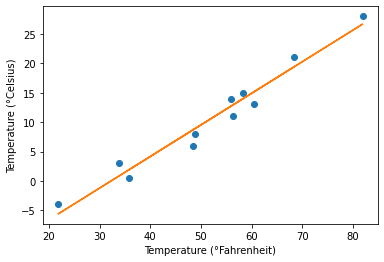

In [105]:
t_p = model(t_un, *params) # make sure to use normalized data to predict as that's what model was trained on

fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°Fahrenheit)")
ax.set_ylabel("Temperature (°Celsius)")
ax.plot(t_u.numpy(), t_c.numpy(), 'o') # raw values
ax.plot(t_u.numpy(), t_p.detach().numpy()) # fitted values

## PyTorch's Autograd
PyTorch remembers operations about tensors that lets it provide the chain of derivatives of those operations with respect to their inputs.

In [115]:
params = torch.tensor([1.0, 0.0], requires_grad=True) 
# track entire family tree of tensors resulting from operations on params

In [109]:
params.grad is None

True

In [116]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad # contains derivative of loss wrt each param, i.e., the gradient of the loss function

tensor([4517.2969,   82.6000])

Note that calling backward will lead derivatives to accumulate at leaf nodes. We need to *zero the gradient* after using it for parameter updates so it doesn't add on top of itself.

In [119]:
if params.grad is not None:
    params.grad.zero_()

New training loop

In [129]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        # autograd mechanism should "look away" meaning it won't add edges to the forward graph
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {float(loss)}')
            
    return params

In [130]:
params = training_loop(5000, 1e-2, torch.tensor([1.0, 0.0], requires_grad=True), t_un, t_c)
params

Epoch 500, Loss 7.860115051269531
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.957697868347168
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286484718322754
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.9276793003082275
Epoch 4500, Loss 2.927651882171631
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

Use built-in optimization strategy instead of training loop

In [132]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [133]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [134]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step() # automatically applied SGD

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

Now replace entire training loop

In [136]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {float(loss)}')
            
    return params

In [139]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
params = training_loop(5000, optimizer, params, t_un, t_c)
params

Epoch 500, Loss 7.860115051269531
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.957697868347168
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286484718322754
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.9276793003082275
Epoch 4500, Loss 2.927651882171631
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

Use different optimizer.

In [141]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)
# can use original t_u as learning rate set adaptively and less sensitive to scaling of params
params = training_loop(2000, optimizer, params, t_u, t_c)
params

Epoch 500, Loss 7.612900257110596
Epoch 1000, Loss 3.086700439453125
Epoch 1500, Loss 2.928579092025757
Epoch 2000, Loss 2.9276442527770996


tensor([  0.5367, -17.3021], requires_grad=True)

## Training, Validation, Overfitting

In [145]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples) # random permutation of ints from 0 to n_samples - 1
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 3,  9,  6,  4,  2,  0, 10,  1,  8]), tensor([5, 7]))

In [146]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

Define new training loop with validation.

In [152]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad(): # do not track autograd graph on validation tensor
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {float(loss)}')
            print(f'\tValidation loss {val_loss:.4f}')
            
    return params

In [153]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
params = training_loop(3000, optimizer, params, train_t_un, val_t_un, train_t_c, val_t_c)

Epoch 1, Loss 92.90481567382812
Validation loss 23.9323
Epoch 2, Loss 32.46635818481445
Validation loss 36.4383
Epoch 3, Loss 25.994890213012695
Validation loss 46.3535
Epoch 500, Loss 9.8406400680542
Validation loss 11.4031
Epoch 1000, Loss 5.113063335418701
Validation loss 2.0225
Epoch 1500, Loss 3.6757562160491943
Validation loss 0.9233
Epoch 2000, Loss 3.238779067993164
Validation loss 1.5555
Epoch 2500, Loss 3.1059255599975586
Validation loss 2.2806
Epoch 3000, Loss 3.0655362606048584
Validation loss 2.7949


In [154]:
params

tensor([  5.5415, -18.3099], requires_grad=True)

## Exercises
1. Note the loss function stays the same.

In [160]:
def new_model(t_u, w2, w1, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [174]:
def new_training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = new_model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = new_model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {float(train_loss)}')
            print(f'\tValidation loss {val_loss:.4f}')
            
    return params

In [175]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True) # holds [w2, w1, b]
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)
params = new_training_loop(10000, optimizer, params, train_t_un, val_t_un, train_t_c, val_t_c)
params

Epoch 1, Loss 764.6103515625
	Validation loss 276.1225
Epoch 2, Loss 409.0584716796875
	Validation loss 174.7018
Epoch 3, Loss 221.0795440673828
	Validation loss 117.0025
Epoch 500, Loss 8.26038646697998
	Validation loss 24.7391
Epoch 1000, Loss 6.830669403076172
	Validation loss 21.1843
Epoch 1500, Loss 5.794828414916992
	Validation loss 18.4018
Epoch 2000, Loss 5.044313430786133
	Validation loss 16.2094
Epoch 2500, Loss 4.500488758087158
	Validation loss 14.4706
Epoch 3000, Loss 4.106388092041016
	Validation loss 13.0826
Epoch 3500, Loss 3.820749044418335
	Validation loss 11.9676
Epoch 4000, Loss 3.613677501678467
	Validation loss 11.0664
Epoch 4500, Loss 3.46352481842041
	Validation loss 10.3339
Epoch 5000, Loss 3.354599952697754
	Validation loss 9.7351
Epoch 5500, Loss 3.2755422592163086
	Validation loss 9.2431
Epoch 6000, Loss 3.2181215286254883
	Validation loss 8.8369
Epoch 6500, Loss 3.17637300491333
	Validation loss 8.5000
Epoch 7000, Loss 3.1459782123565674
	Validation loss 8.

tensor([ 0.5673, -0.9551, -0.8040], requires_grad=True)

As the validation loss is higher, here the result is worse with the more complex model.